# Экспериментальное исследование алгоритмов для регулярных запросов
### Постановка задачи:
В этой работе поставлена задача исследовать два алгоритма решения задачи достижимости с регулярными ограничениями в графе между всеми парами стартовых вершин и с заданным множеством.

Для решения поставленной задачи необходимо ответить на следующие вопросы:
- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

### Исследуемые решения
В работе сравнивались следующие алгоритмы:
1) ms_bfs_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int], final_nodes: set[int], matrix_type) -> set[tuple[int, int]] - матричный алгоритм решения задачи достижимости в графе
2) tensor_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int], final_nodes: set[int], matrix_type) -> set[tuple[int, int]] - тензорный алгоритм решения задачи достижимости в графе


- regex- регулярные ограничения
- graph- граф, для которого решается задача достижимости
- start_nodes- множество стартовых вершин графа, если равно пустому множеству, то стартовыми вершинами будут все вершины графа
- final_nodes- конечные вершины графа, всегда выбираются все вершины по аналогии с start_nodes
- matrix_type- тип разреженных матриц, используемых в алгоритме

В эксперименте используются следющие виды матриц: dok_matrix, lil_matrix, csc_matrix, csr_matrix.

Исходя из документации к каждому из видов матриц, можно привести следующую характеристику для каждого вида:

▌1. dok_matrix (Dictionary of Keys)

- Описание: Эта матрица представляет собой словарь, где ключами являются координаты ненулевых элементов (например, (i, j)), а значениями — сами элементы.
- Преимущества:
 - Позволяет быстро добавлять новые элементы (O(1)).
 - Удобен для динамического построения матрицы.
- Недостатки:
 - Не самый эффективный формат для большинства операцией с матрицами.
 - Не оптимизирован для быстрого доступа к элементам по индексам.

▌2. lil_matrix (List of Lists)

- Описание: Эта матрица представляет собой список списков, где каждый элемент списка содержит ненулевые элементы в строке вместе с их индексами.
- Преимущества:
 - Удобен для инкрементного строительства матрицы (постепенного добавления элементов).
 - Легко модифицировать и добавлять новые элементы.
- Недостатки:
 - Неэффективен для быстрого доступа к элементам и выполнения операций матричного умножения.

▌3. csc_matrix (Compressed Sparse Column)

- Описание: Формат, который хранит ненулевые элементы по колонкам, что оптимизирует доступ к элементам в колонках.
- Преимущества:
 - Эффективен для операций, которые в основном оперируют по столбцам, например, для умножения на векторы.
 - Позволяет быстро извлекать колонки матрицы.
- Недостатки:
 - Достаточно сложный в изменении, если требуется часто добавлять или удалять элементы.

▌4. csr_matrix (Compressed Sparse Row)

- Описание: Подобно csc_matrix, но хранит ненулевые элементы по строкам, что оптимизирует доступ к элементам в строках.
- Преимущества:
 - Эффективен для операций, которые требуют доступа к строкам, особенно для матричного умножения.
 - Быстрый доступ к строкам и эффективное хранение памяти.
- Недостатки:
 - Не оптимален для операций, требующих частых манипуляций с элементами матрицы (например, добавление/удаление).


### Набор данных для эксперимента:
Из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html) были взяты следующие графы:
- skos — 144 nodes, 252 edges;
- wine — 733 nodes, 1839 edges;
- funding — 778 nodes, 1086 edges;

Данные графы были взяты по причине их небольшого размера, при этом у каждого из них есть уникальные свойства, которые позволят провести качественный эксперимент.
В частности, у графа funding количество вершин и узлов отличается на 308, а в графе wine - больше чем в два раза. В сравнении можно сказать, что в графе funding и  skos количество узлов почти не отличается от количества ребер.

### Регулярные выражения
В ходе работы будут использованы следующие регулярные выражения:

- (l1 | l2) (l3 | l4)
- (l1 | l2)* l3
- (l3 | l4)+ l1*
- l1 l2 l3 (l4|l1)*

l1, l2, l3, l4 - это наиболее часто встречающиеся метки в графах

## Описание эксперимента
### Оборудование

Процессор: Apple Silicon M1 (8 ядер, 4x Firestorm + 4x Icestorm cores)

Кэш: L1 - 256 KB, L2 - 16 MB общий (12 МБ - Firestorm, 4 МБ - Icestorm), L3 - 16 MБ

Оперативная память - 16 GB

ОС - MacOS Sequoia 15.3

Python 3.12.5

## Проведение эксперимента

При сравнении двух алгоритмов, на результат эксперимента могут повлиять различные факторы, такие как: вид матрицы, вид графа, количество стартовых вершин, и регулярное ограничение. В ходе эксперимента будут проведены замеры со всеми возможными комбинациями этих параметров. Замер каждой комбинации проводился 25 раз, где вычислялось среднее значение и стандартное отклонение.


In [8]:
from itertools import product
from collections import defaultdict
from project.hw1.graph_builder import load_graph, get_graph
from project.hw3.AdjacencyMatrixFA import tensor_based_rpq
from project.hw4.ms_rpq import ms_bfs_based_rpq
from cfpq_data import generate_multiple_source
from scipy import stats
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [9]:
matrix_types = {
    "dok": sp.dok_matrix,
    "lil": sp.lil_matrix,
    "csc": sp.csc_matrix,
    "csr": sp.csr_matrix,
}

start_nodes_percent = [5, 25, 50, 70, 100]

algos = [tensor_based_rpq, ms_bfs_based_rpq]

run_num = 25


def get_labels(name: str, num: int):
    return load_graph(name).labels[:num]


def get_regexes_4_labels(labels):
    return (
        f"({labels[0]} | {labels[1]}) ({labels[2]} | {labels[3]})",
        f"({labels[0]} | {labels[1]})* {labels[2]}",
        f"({labels[2]} | {labels[3]})+ {labels[0]}*",
        f"{labels[0]} {labels[1]} {labels[2]} ({labels[3]}|{labels[0]})*",
    )


def get_regexes_for_graph(name: str):
    labels = get_labels(name, 4)
    return get_regexes_4_labels(labels)


def get_start_nodes(graph, percent):
    if percent == 100:
        return set()
    seed = 0xEBAC0C
    return generate_multiple_source(
        graph, graph.number_of_nodes() * percent // 100, seed=seed
    )

def measure_time(graph, regex, start, matrix_type, func):
    time1 = time.perf_counter()
    func(regex, graph, start, final_nodes=set(), matrix_type=matrix_type)
    time2 = time.perf_counter()
    return time2 - time1


def test_graph(name: str, num: int):
    graph = get_graph(name)
    regexes = get_regexes_for_graph(name)
    measures_dict = defaultdict(lambda: defaultdict(list))
    for percent in start_nodes_percent:
        start = get_start_nodes(graph, percent)
        measures_dict[percent] = [
            [measure_time(graph, regex, start, matrix_type, algo) for _ in range(num)]
            for matrix_type, regex, algo in product(
                matrix_types.values(), regexes, algos
            )
        ]

    return measures_dict

def analyze_execution_times_avg(measures_dict):
    data = {
        "Start percent": [],
        "Matrix Type": [],
        "Regex": [],
        "Algorithm": [],
        "Mean Time (s)": [],
        "Std Dev (s)": [],
        "95% CI Low": [],
        "95% CI High": [],
    }

    regexes = get_regexes_4_labels(["l0", "l1", "l2", "l3"])
    algorithms = ["tensor_based_rpq", "ms_bfs_based_rpq"]

    for percent, measures in measures_dict.items():
        for num, (matrix_type, regex, algorithm) in enumerate(
            product(matrix_types.keys(), regexes, algorithms)
        ):
            measure = measures[num]
            mean_time = np.mean(measure)
            std_dev = np.std(measure, ddof=1)
            ci95 = stats.t.ppf(0.975, df=len(measure) - 1) * stats.sem(measure)

            data["Start percent"].append(percent)
            data["Matrix Type"].append(matrix_type)
            data["Regex"].append(regex)
            data["Algorithm"].append(algorithm)
            data["Mean Time (s)"].append(mean_time)
            data["Std Dev (s)"].append(std_dev)
            data["95% CI Low"].append(mean_time - ci95)
            data["95% CI High"].append(mean_time + ci95)

    df = pd.DataFrame(data)
    return df

def create_bar(
    name,
    result,
    matrices=matrix_types.keys(),
    percents=start_nodes_percent,
    algos=["tensor_based_rpq", "ms_bfs_based_rpq"],
):
    regexes = get_regexes_4_labels(["l0", "l1", "l2", "l3"])
    for percent, algo in product(percents, algos):
        index = np.arange(4)
        bw = 0.2
        plt.title(
            f"Graph {name} with {percent}% of start nodes and {algo} algorithm",
            fontsize=15,
        )
        plt.xticks(index + 1.5 * bw, regexes)
        percent_result = result[
            (result["Start percent"] == percent) & (result["Algorithm"] == algo)
        ]
        colors = ["b", "r", "g", "m"]
        for i, matrix in enumerate(matrices):
            matrix_result = percent_result[
                (percent_result["Matrix Type"] == matrix)
                & (percent_result["Algorithm"] == algo)
            ]
            plt.bar(
                index + i * bw,
                matrix_result["Mean Time (s)"].values,
                bw,
                color=colors[i],
                yerr=matrix_result["Std Dev (s)"].values,
                error_kw={"ecolor": "0.1", "capsize": 6},
                label=matrix,
            )
        plt.legend(loc=2)
        plt.show()

In [10]:
result = test_graph("skos", run_num)

[2025-01-30 23:27:21]>INFO>Found graph with name='skos'
[2025-01-30 23:27:23]>INFO>Load archive graph_archive=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2025-01-30 23:27:23]>INFO>Unzip graph name='skos' to file graph=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2025-01-30 23:27:23]>INFO>Remove archive graph_archive=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2025-01-30 23:27:23]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x13306a300> from path=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2025-01-30 23:27:23]>INFO>Fou

Сейчас были проведены замеры для графа scos, результаты отображены в таблице ниже:

In [11]:
table = analyze_execution_times_avg(result)
table

,Start percent,Matrix Type,Regex,Algorithm,Mean Time (s),Std Dev (s),95% CI Low,95% CI High
0,5,dok,(l0 | l1) (l2 | l3),tensor_based_rpq,0.025721,0.021911,0.016677,0.034765
1,5,dok,(l0 | l1) (l2 | l3),ms_bfs_based_rpq,0.007482,0.000547,0.007257,0.007708
2,5,dok,(l0 | l1)* l2,tensor_based_rpq,0.013186,0.000509,0.012975,0.013396
3,5,dok,(l0 | l1)* l2,ms_bfs_based_rpq,0.006664,0.000343,0.006522,0.006806
4,5,dok,(l2 | l3)+ l0*,tensor_based_rpq,0.020644,0.000610,0.020393,0.020896
...,...,...,...,...,...,...,...,...
155,100,csr,(l0 | l1)* l2,ms_bfs_based_rpq,0.042041,0.000592,0.041797,0.042285
156,100,csr,(l2 | l3)+ l0*,tensor_based_rpq,0.019149,0.000286,0.019030,0.019267
157,100,csr,(l2 | l3)+ l0*,ms_bfs_based_rpq,0.044942,0.012714,0.039694,0.050189
158,100,csr,l0 l1 l2 (l3|l0)*,tensor_based_rpq,0.019877,0.000344,0.019735,0.020019



Если отобразить замеры в виде диаграммы, то можно более наглядно ознакомиться с результатом:

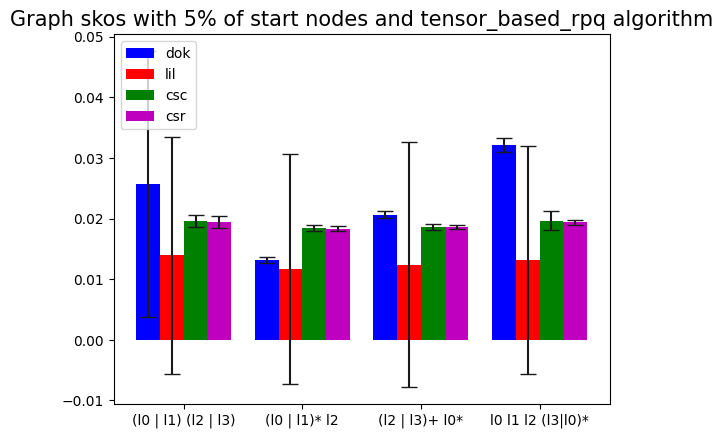

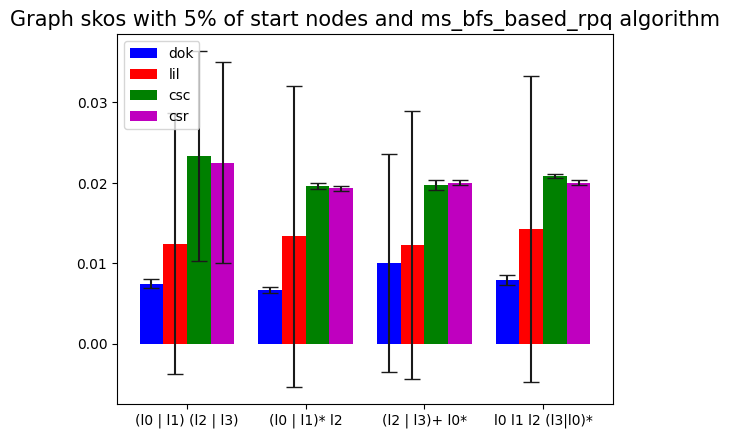

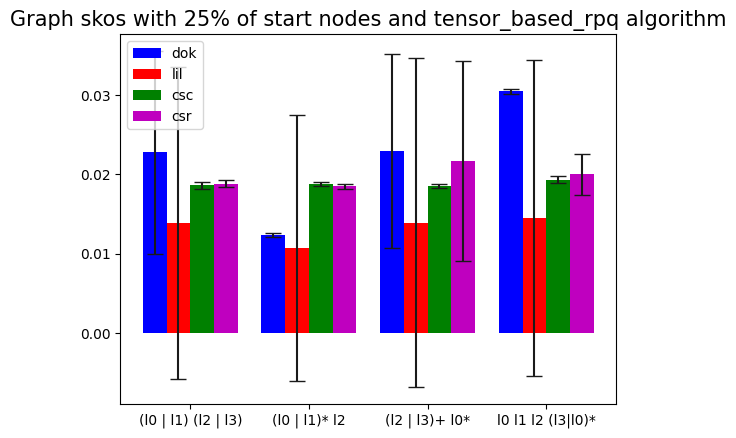

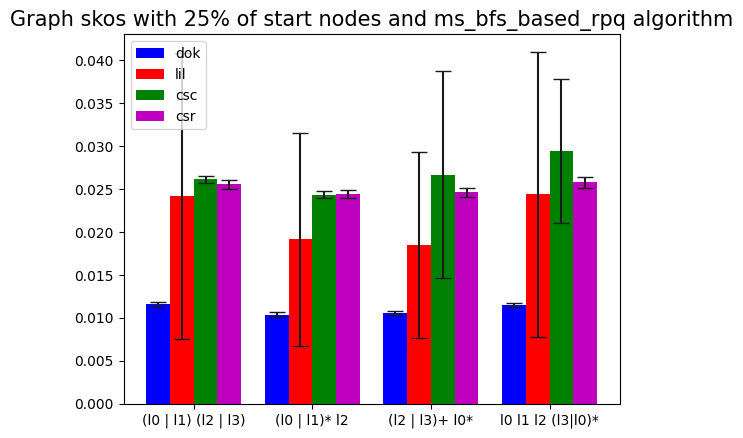

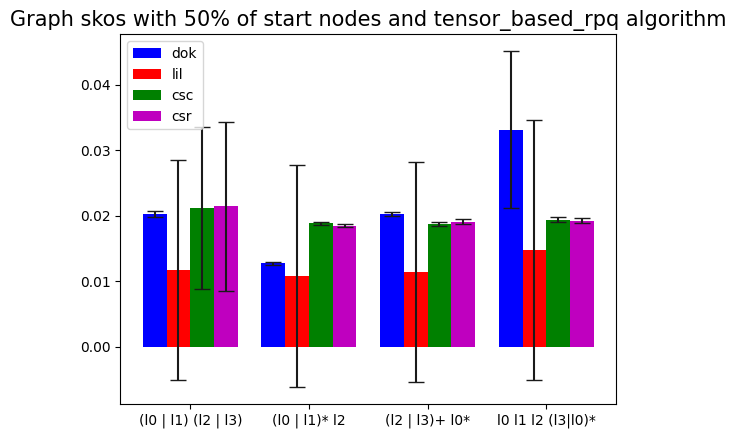

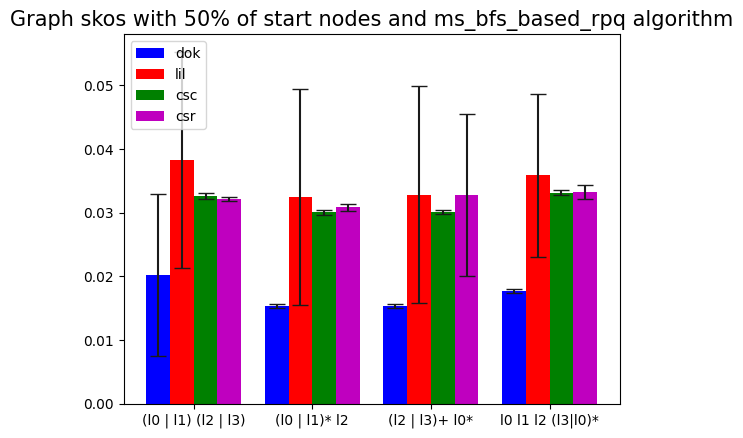

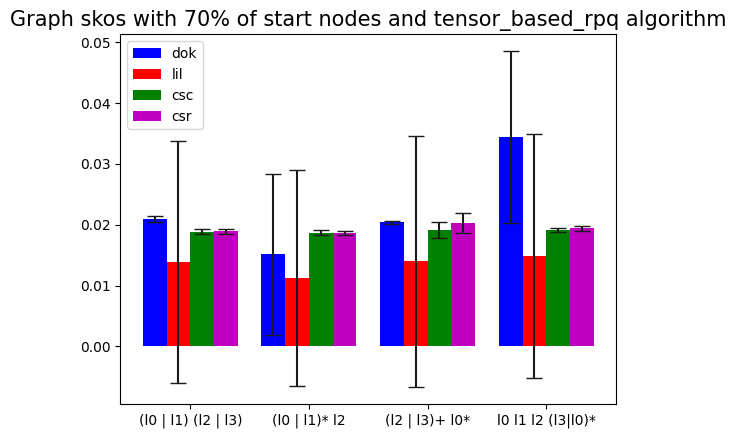

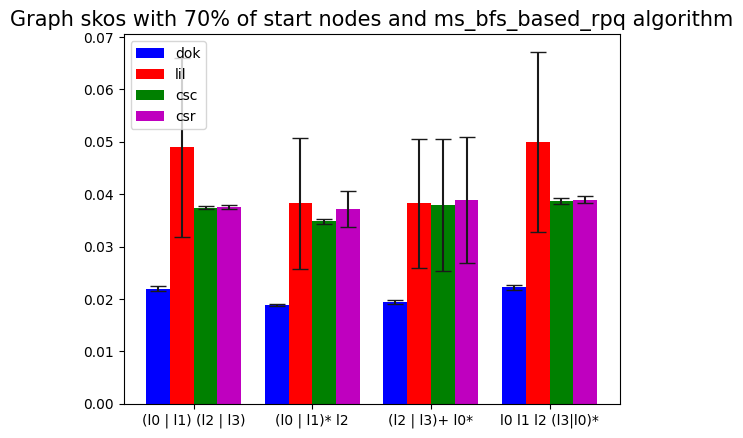

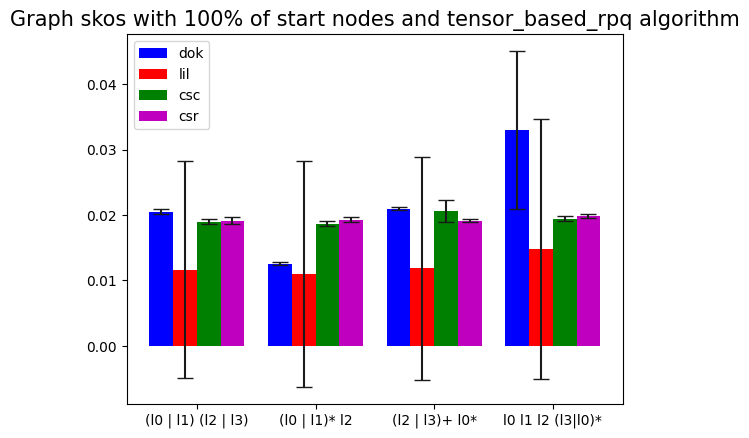

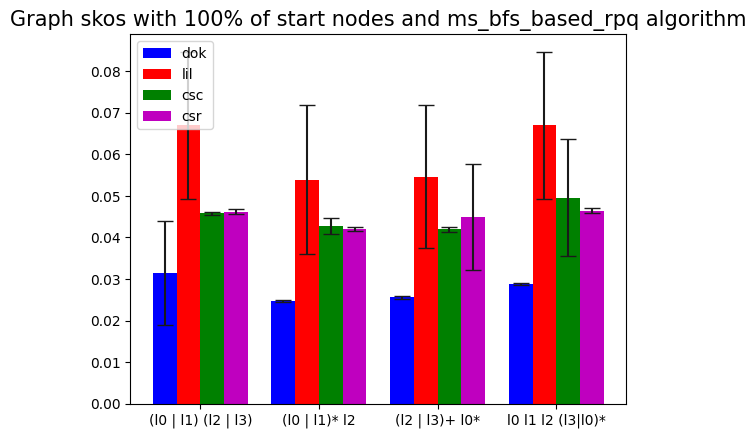

In [12]:
create_bar("skos", table, percents=start_nodes_percent)

Посмотрев на диаграммы можно заметить, что тензорный алгоритм работает хуже всего при маленьком количестве стартовых вершин с матрицей dok. Но также прослеживается тенденция на улучшение ситуации при увеличении количества стартовых вершин с матрицами другого вида. В среднем, на малом количестве вершин скорость тензорного алгоритма не сильно отличается от матричного, но при увеличении их количества тензорный алгоритм выигрывает по времени, начиная с 50 процентов вершин разница почти в два раза (за исключением dok матрицы).

Также можно отметить, что независимо от количества вершин, с матрицей lil тензорный алгоритм работает всегда лучше, чем матричный.
Матричный алгоритм в свою очередь всегда хорошо работает с матрицей dock, обгоняя тензорный алгоритм при любом количестве стартовых вершин.
С матрицами csc и csr тензорный алгоритм начинает обгонять матричный при росте количества вершин, как уже было сказано выше.






In [13]:
res2 = test_graph("wine", run_num)

[2025-01-31 00:18:16]>INFO>Found graph with name='wine'
[2025-01-31 00:18:19]>INFO>Load archive graph_archive=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/wine.tar.gz')
[2025-01-31 00:18:19]>INFO>Unzip graph name='wine' to file graph=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/wine/wine.csv')
[2025-01-31 00:18:19]>INFO>Remove archive graph_archive=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/wine.tar.gz')
[2025-01-31 00:18:19]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x135ec4ec0> from path=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/wine/wine.csv')
[2025-01-31 00:18:19]>INFO>Fou

In [14]:
table2 = analyze_execution_times_avg(res2)
table2

,Start percent,Matrix Type,Regex,Algorithm,Mean Time (s),Std Dev (s),95% CI Low,95% CI High
0,5,dok,(l0 | l1) (l2 | l3),tensor_based_rpq,0.396545,0.049838,0.375973,0.417117
1,5,dok,(l0 | l1) (l2 | l3),ms_bfs_based_rpq,0.051718,0.024943,0.041423,0.062014
2,5,dok,(l0 | l1)* l2,tensor_based_rpq,0.227524,0.068515,0.199242,0.255805
3,5,dok,(l0 | l1)* l2,ms_bfs_based_rpq,0.049112,0.024577,0.038967,0.059257
4,5,dok,(l2 | l3)+ l0*,tensor_based_rpq,0.382782,0.027830,0.371295,0.394270
...,...,...,...,...,...,...,...,...
155,100,csr,(l0 | l1)* l2,ms_bfs_based_rpq,0.287742,0.045852,0.268815,0.306668
156,100,csr,(l2 | l3)+ l0*,tensor_based_rpq,0.165587,0.036026,0.150716,0.180458
157,100,csr,(l2 | l3)+ l0*,ms_bfs_based_rpq,0.284949,0.040372,0.268284,0.301614
158,100,csr,l0 l1 l2 (l3|l0)*,tensor_based_rpq,0.165870,0.033513,0.152037,0.179703


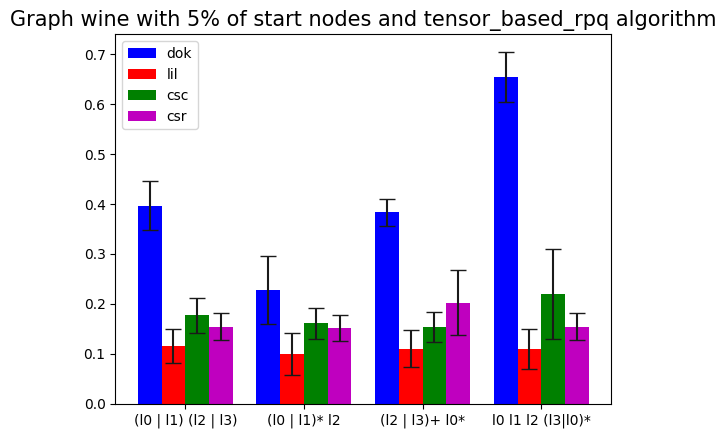

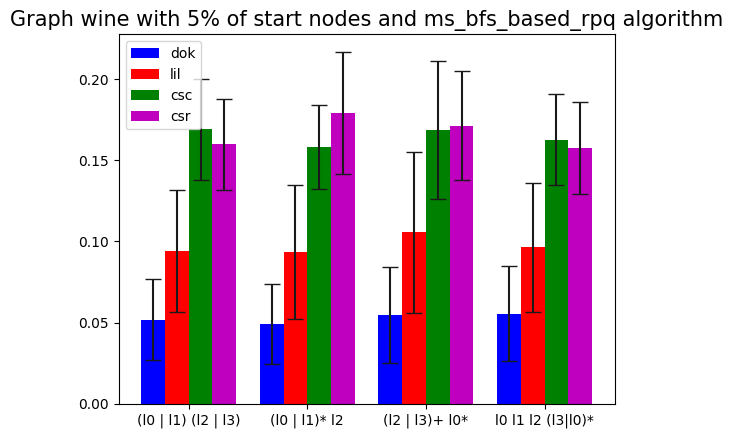

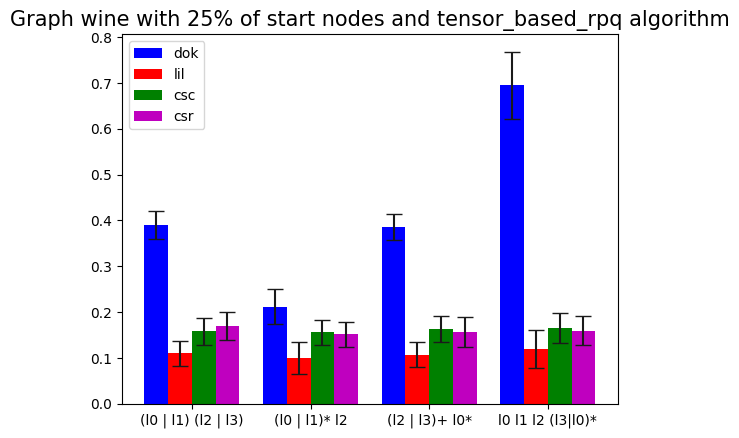

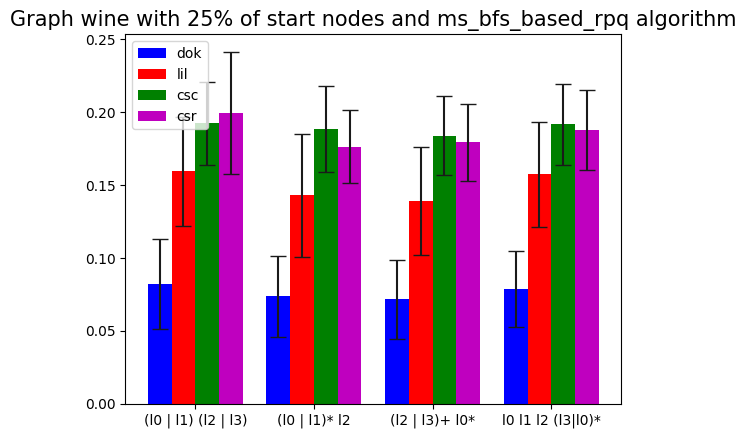

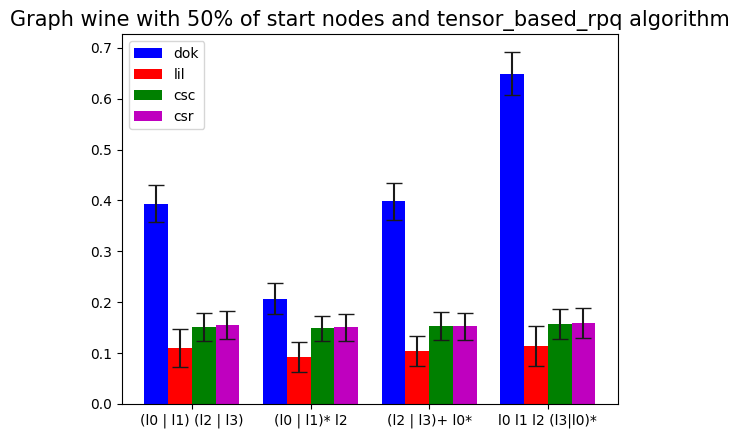

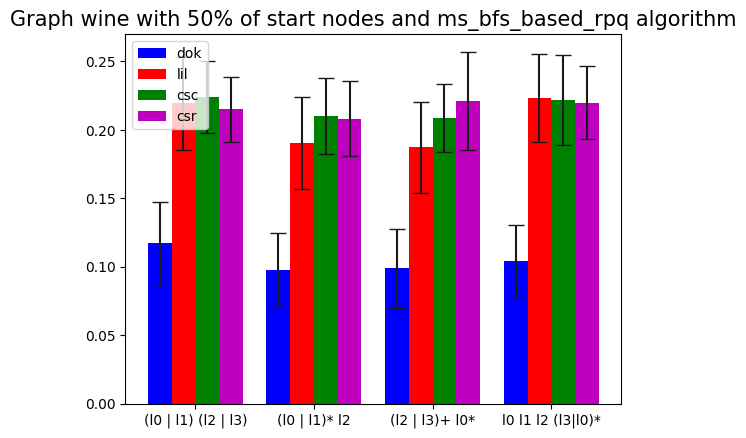

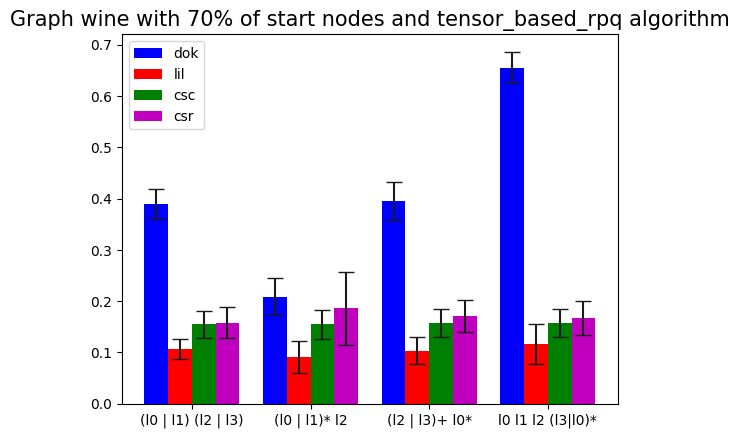

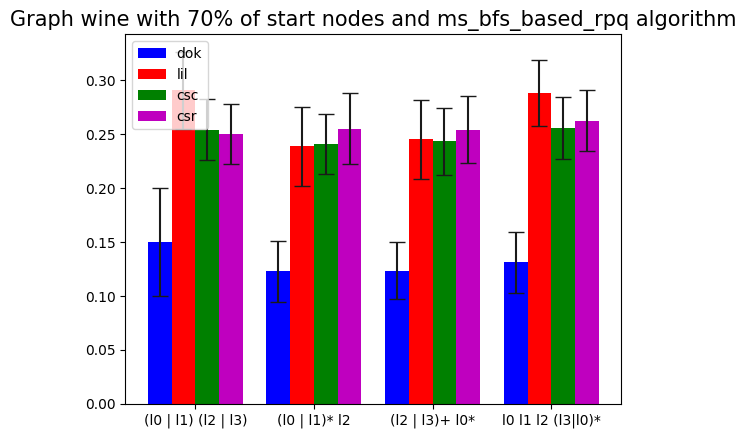

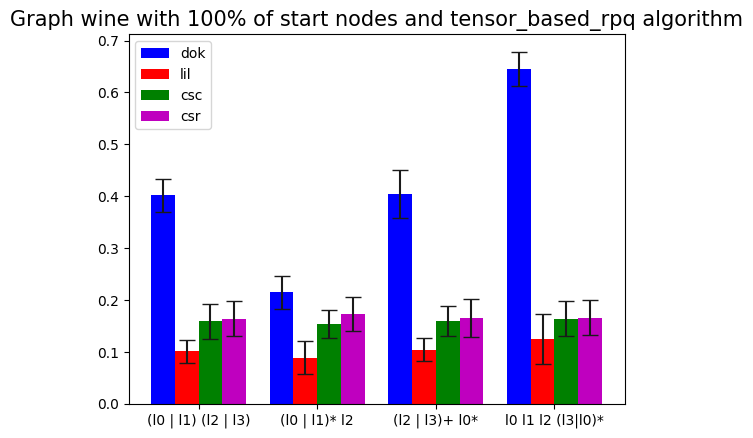

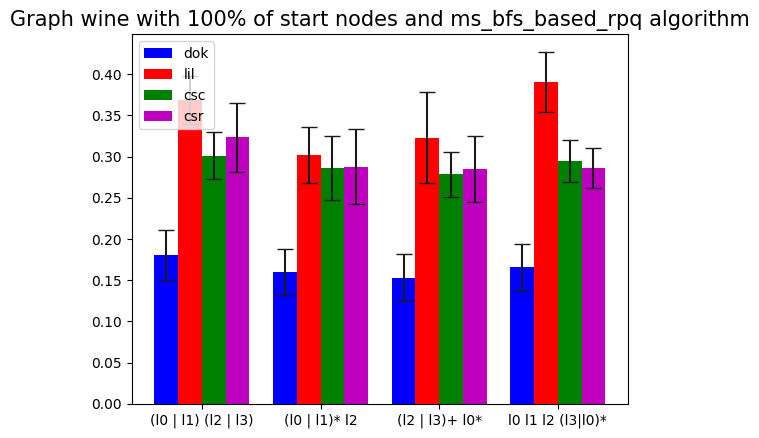

In [15]:
create_bar("wine", table2, percents=start_nodes_percent)

Анализируя ситуацию с текущим графом "wine", можно прийти к тем же выводам, которые были сделаны для предыдущего графа. Наилучшим образом в тензорном алгоритме себя показывает матрица lil, а в матричном - dok.



In [16]:
res3 = test_graph("funding", run_num)


[2025-01-31 00:41:46]>INFO>Found graph with name='funding'
[2025-01-31 00:41:48]>INFO>Load archive graph_archive=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/funding.tar.gz')
[2025-01-31 00:41:48]>INFO>Unzip graph name='funding' to file graph=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/funding/funding.csv')
[2025-01-31 00:41:48]>INFO>Remove archive graph_archive=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/funding.tar.gz')
[2025-01-31 00:41:48]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x1335c1b20> from path=PosixPath('/Users/nikitalukonenko/Studying/third_course/formalki/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/funding/funding.csv')
[2025-

In [17]:
table3 = analyze_execution_times_avg(res2)
table3

,Start percent,Matrix Type,Regex,Algorithm,Mean Time (s),Std Dev (s),95% CI Low,95% CI High
0,5,dok,(l0 | l1) (l2 | l3),tensor_based_rpq,0.396545,0.049838,0.375973,0.417117
1,5,dok,(l0 | l1) (l2 | l3),ms_bfs_based_rpq,0.051718,0.024943,0.041423,0.062014
2,5,dok,(l0 | l1)* l2,tensor_based_rpq,0.227524,0.068515,0.199242,0.255805
3,5,dok,(l0 | l1)* l2,ms_bfs_based_rpq,0.049112,0.024577,0.038967,0.059257
4,5,dok,(l2 | l3)+ l0*,tensor_based_rpq,0.382782,0.027830,0.371295,0.394270
...,...,...,...,...,...,...,...,...
155,100,csr,(l0 | l1)* l2,ms_bfs_based_rpq,0.287742,0.045852,0.268815,0.306668
156,100,csr,(l2 | l3)+ l0*,tensor_based_rpq,0.165587,0.036026,0.150716,0.180458
157,100,csr,(l2 | l3)+ l0*,ms_bfs_based_rpq,0.284949,0.040372,0.268284,0.301614
158,100,csr,l0 l1 l2 (l3|l0)*,tensor_based_rpq,0.165870,0.033513,0.152037,0.179703


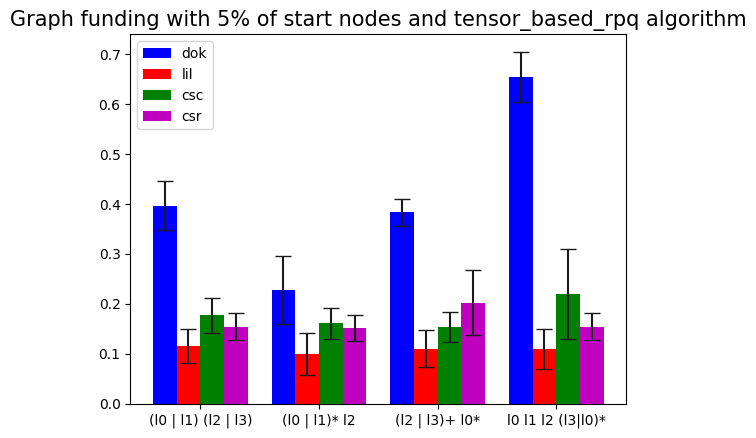

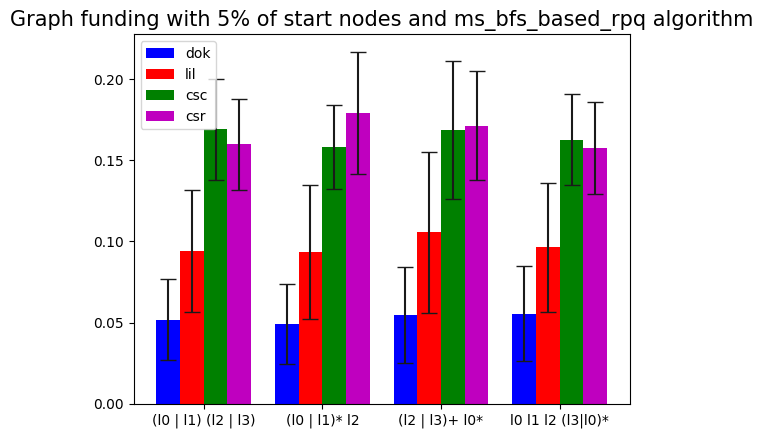

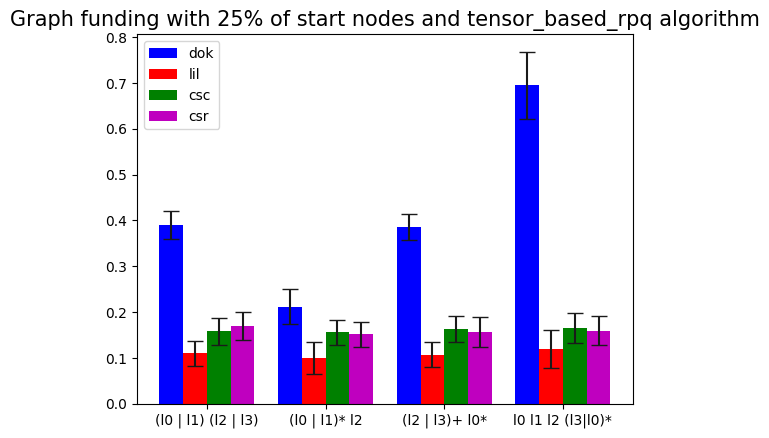

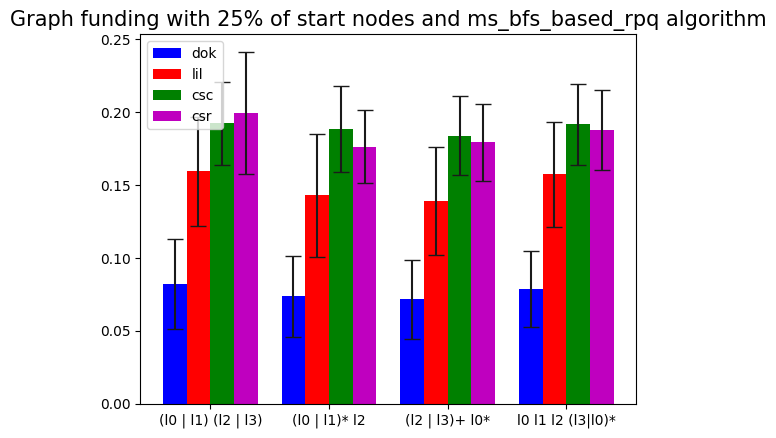

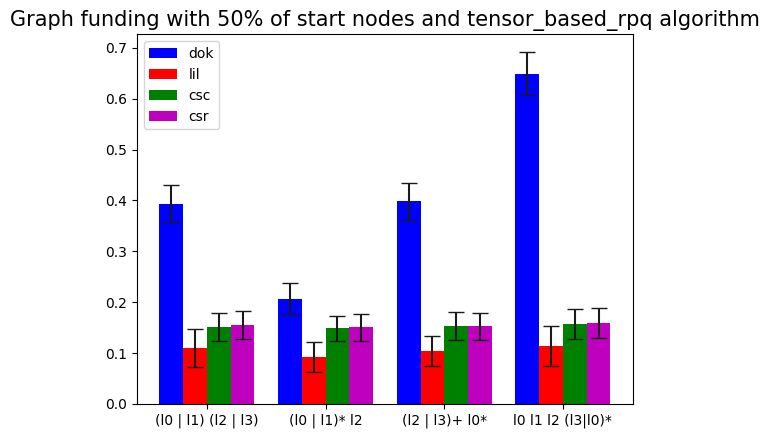

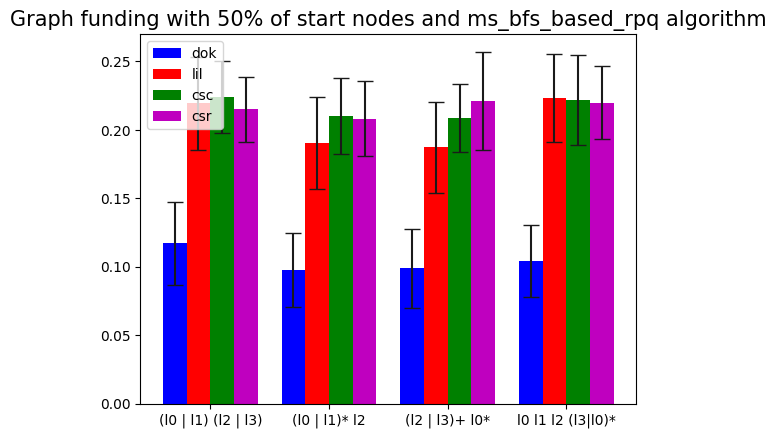

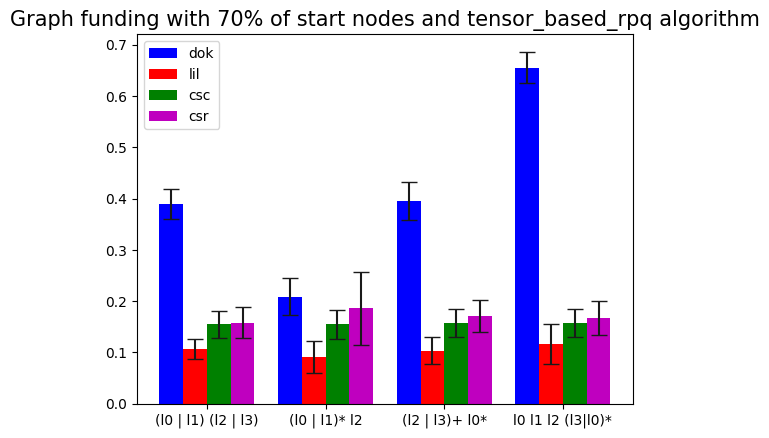

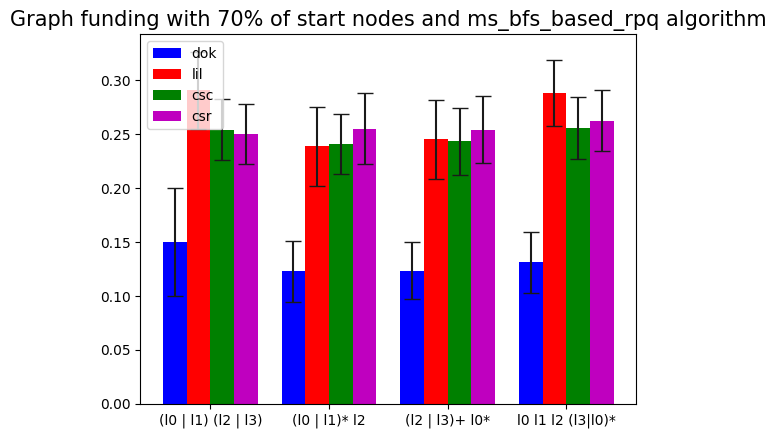

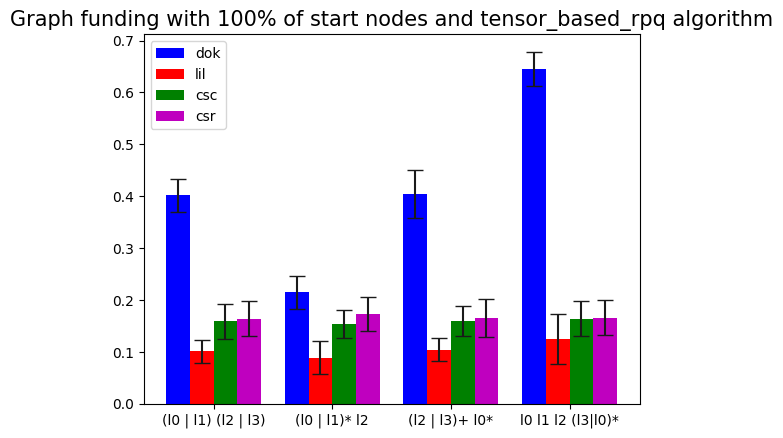

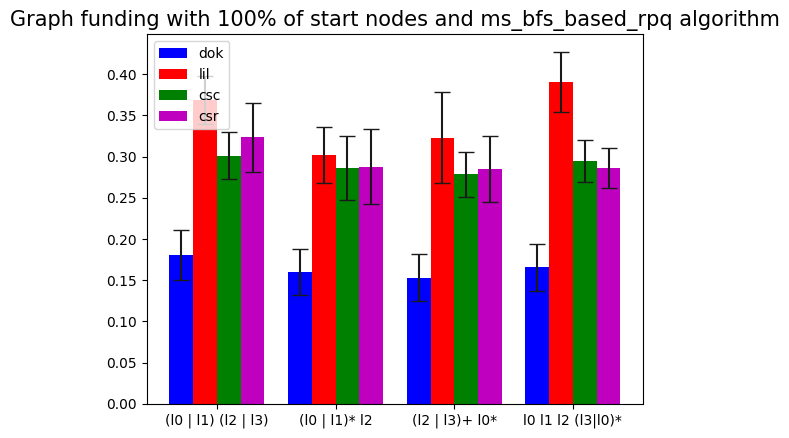

In [18]:
create_bar("funding", table3, percents=start_nodes_percent)

Если сравнить получившиеся результаты с теми, что были получены для wine, и scos, то можно заметить, что большое количество ребер (в сравнении с количеством вершин) никак не повлияло на общую картину, и результаты для графа funding аналогичны тем, что были у графов wine и scos.


## Результаты
1) Для матричного алгоритма хорошо подходит dok матрица, также при малом количестве стартовых узлов можно использовать lil матрицу, проигрывать она не будет. Алгоритм хорошо работает с малым количеством стартовых узлов.
2) Для тензорного алгоритма хорошо подходит lil матрица, он хорошо с ней работает независимо от количества стартовых вершин. При росте количества стартовых вершин он сравнительно хорошо себя показывает на фоне матричного алгоритма.
3) При решении задачи достижимости с количеством стартовых узлов большим, чем 50 процентов от общего количества, выгодно решать задачу для всего множества стартовых вершин целиком.
